BWA and minimap2 resulted in slightly different variant calling validation results, running on the ICGC MB dataset (100x tumor vs 100x normal). Trying to understand the origin of that discrepancy.

In [39]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statistics import median, mean
from pprint import pprint
import sys

Parsing VCF for Strelka2, VarDict, and Mutect2 paired somatic calls. Earlier we evaluated calls against the truth set, so here we have 3 sets of VCFs for each caller: `0000.vcf` (false positives), `0001.vcf` (false negatives), `0002.vcf` (true positives).

In [33]:
from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from os.path import join
from collections import Counter
import tabix

callers = ['strelka2', 'vardict', 'mutect2']

vcfs = {}
for c in callers:
    bwa_dir = f'mb_eval/batch1-{c}-annotated-bwa_bcftools_isec'
    mm2_dir = f'mb_eval/batch1-{c}-annotated_bcftools_isec'
    vcfs[c] = dict(
        bwa=dict(
            fp=join(bwa_dir, '0000.fixed.anno.vcf.gz'),
            fn=join(bwa_dir, '0001.fixed.anno.vcf.gz'),
            tp=join(bwa_dir, '0002.fixed.anno.vcf.gz'),
        ),
        mm2=dict(
            fp=join(mm2_dir, '0000.fixed.anno.vcf.gz'),
            fn=join(mm2_dir, '0001.fixed.anno.vcf.gz'),
            tp=join(mm2_dir, '0002.fixed.anno.vcf.gz'),
        ),
    )
validate_types = ['fp', 'tp', 'fn']

main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

def extract_mq(rec_, caller_):
    if rec_ is None:
        return None
    if caller_ == 'vardict':
        try:
            return rec_.format('MQ')[main_sample_index][0]
        except:
            print(rec_)
            raise
    if caller_ == 'strelka2':
        try:
            return rec_.INFO['MQ']
        except:
            print(rec_)
            raise
    if caller_ == 'mutect2':
        return rec_.format('MMQ')[main_sample_index][0] if rec_ else None
    
def int_to_chrom(val):
    if val == 23: return 'X'
    if val == 24: return 'Y'
    if val == 25: return 'MT'
    if val == 0: return None
    return str(val)
    
def chrom_to_int(chrom):
    if chrom == 'X': return 23
    if chrom == 'Y': return 24
    if chrom == 'MT': return 25
    try:
        return int(chrom)
    except:
        return 0

t = '''
1	249250621	52	60	61
2	243199373	253404903	60	61
3	198022430	500657651	60	61
4	191154276	701980507	60	61
5	180915260	896320740	60	61
6	171115067	1080251307	60	61
7	159138663	1254218344	60	61
8	146364022	1416009371	60	61
9	141213431	1564812846	60	61
10	135534747	1708379889	60	61
11	135006516	1846173603	60	61
12	133851895	1983430282	60	61
13	115169878	2119513096	60	61
14	107349540	2236602526	60	61
15	102531392	2345741279	60	61
16	90354753	2449981581	60	61
17	81195210	2541842300	60	61
18	78077248	2624390817	60	61
19	59128983	2703769406	60	61
20	63025520	2763883926	60	61
21	48129895	2827959925	60	61
22	51304566	2876892038	60	61
X	155270560	2929051733	60	61
Y	59373566	3086910193	60	61
MT	16569	3147273397	70	71
'''
chrom_lens = [(l.split('\t')[0], int(l.split('\t')[1])) for l in t.split('\n') if l.strip()]
chrom_positions = [(chrom, sum(l for c, l in chrom_lens if chrom_to_int(c) < chrom_to_int(chrom))) 
                        for chrom, _ in chrom_lens] \
                   + [(None, sum(l for c, l in chrom_lens))]

# def check_tricky_regions(rec):
#     fpath = 'tricky.bed.gz'
#     tb = tabix.open(fpath)
#     recs = tb.query(rec.CHROM, rec.POS, rec.end)
#     r = ','.join(r[3] for r in recs)
#     return r

recs_by_loc_by_c = {c: dict() for c in callers}
for c in callers:
    print('Parsing VCFs for ' + c)
    d = {}
    
    for typ, vcf in vcfs[c]['bwa'].items():
        for rec in VCF(vcf):            
            if rec.FILTER:
                continue
            k = (rec.CHROM, rec.POS, rec.ALT[0])
            if k not in d:
                d[k] = [(None, 'tn'), (None, 'tn')]
            d[k][0] = (rec, typ)
            
    for typ, vcf in vcfs[c]['mm2'].items():
        for rec in VCF(vcf):
            if rec.FILTER:
                continue
            k = (rec.CHROM, rec.POS, rec.ALT[0])
            if k not in d:
                d[k] = [(None, 'tn'), (None, 'tn')]
            d[k][1] = (rec, typ)
    
    recs_by_loc_by_c[c] = d

df_by_c = dict()
for caller in callers:
    print(f'Analysing data for {caller}, building dataframe')
    recs_by_loc = recs_by_loc_by_c[caller]
    d = []
    total = 0
    for (chrom, pos, alt), [(bwa, bwa_t), (mm2, mm2_t)] in sorted(recs_by_loc.items(), key=lambda a: a[0]):    
        total += 1
        
        x = next((p for c, p in chrom_positions if str(c) == str(chrom)), None)
        if x is None:
            continue
        x += pos
                
        gene = ''
        if bwa_t.endswith('n'):
            bwa_dp = 0
            bwa_af = 0
            bwa_qual = 0
            bwa_mq = 0
            bwa_nm = 0
        else:
            try:
                bwa_af = bwa.format('AF')[main_sample_index]
            except:
                bwa_af = bwa.INFO.get('AF')
            try:
                bwa_dp = bwa_dp = bwa.format('DP')[main_sample_index]
            except:
                bwa_dp = bwa.INFO.get('DP')                
            if not isinstance(bwa_af, (int, float)): bwa_af = bwa_af[0]
            if not isinstance(bwa_dp, (int, float)): bwa_dp = bwa_dp[0]
            bwa_qual = bwa.QUAL
            if 'ANN' in bwa.INFO:
                gene = bwa.INFO['ANN'].split('|')[3]
            bwa_mq = extract_mq(bwa, caller) or 0
            bwa_nm = bwa.format('NM')[main_sample_index][0] if caller == 'vardict' else None
            
        if mm2_t.endswith('n'):
            mm2_dp = 0
            mm2_af = 0
            mm2_qual = 0
            mm2_mq = 0
            mmq_nm = 0
        else:
            try:
                mm2_af = mm2.format('AF')[main_sample_index]
            except:
                mm2_af = mm2.INFO.get('AF')
            try:
                mm2_dp = mm2_dp = mm2.format('DP')[main_sample_index]
            except:
                mm2_dp = mm2.INFO.get('DP')                
            if not isinstance(mm2_af, (int, float)): mm2_af = mm2_af[0]
            if not isinstance(mm2_dp, (int, float)): mm2_dp = mm2_dp[0]
            mm2_qual = mm2.QUAL
            if 'ANN' in mm2.INFO:
                gene = mm2.INFO['ANN'].split('|')[3]
            mm2_mq = extract_mq(mm2, caller) or 0
            mm2_nm = mm2.format('NM')[main_sample_index][0] if caller == 'vardict' else None
               
        tricky_anno = ','.join([v for k, v in (bwa or mm2).INFO 
                                if k.startswith('TRICKY_') and not 'heng_um75-hs37d5' in k])
                
        d.append({
            'pos': pos,
            'label': f'{chrom}:{pos}-{alt}', 
            'called_with_bwa': bwa is not None,
            'called_with_mm2': mm2 is not None,
            'chrom': chrom,
            'x': x,
            'passed': not (bwa or mm2).FILTER,
            'gene': gene,
            'bwa_af': bwa_af,
            'mm2_af': mm2_af,
            'bwa_dp': bwa_dp,
            'mm2_dp': mm2_dp,
            'bwa_mq': bwa_mq, 
            'mm2_mq': mm2_mq,
            'bwa_qual': bwa_qual,
            'mm2_qual': mm2_qual,
            'mq_diff': bwa_mq - mm2_mq,
            'bwa_nm': bwa_nm,
            'mm2_nm': mm2_nm,
            'bwa_validate': bwa_t,
            'mm2_validate': mm2_t,
            'tricky_anno': tricky_anno,
        }) 

    df = pd.DataFrame(d)
    df_by_c[caller] = df

    print(f'Done parsing {caller}, total variants: ', str(total))

Parsing VCFs for strelka2
Parsing VCFs for vardict
Parsing VCFs for mutect2
Analysing data for strelka2, building dataframe
Done parsing strelka2, total variants:  2725
Analysing data for vardict, building dataframe
Done parsing vardict, total variants:  27146
Analysing data for mutect2, building dataframe
Done parsing mutect2, total variants:  13251


Counting statistics on variants calls with BWA only vs. minimap2 only vs. shared, drawing Venn diagrams for each caller.

strelka2
('fn', 'fn') 3872
('fn', 'tp') 2222
('fp', 'fp') 3366
('fp', 'tn') 10824
('tn', 'fp') 10186
('tp', 'fn') 3344
('tp', 'tp') 25982
vardict
('fn', 'fn') 7656
('fn', 'tp') 1958
('fp', 'fp') 27346
('fp', 'tn') 297022
('tn', 'fp') 223388
('tp', 'fn') 2244
('tp', 'tp') 23562
mutect2
('fn', 'fn') 3388
('fn', 'tp') 2134
('fp', 'fp') 11176
('fp', 'tn') 208692
('tn', 'fp') 33704
('tp', 'fn') 2596
('tp', 'tp') 27302
Done all


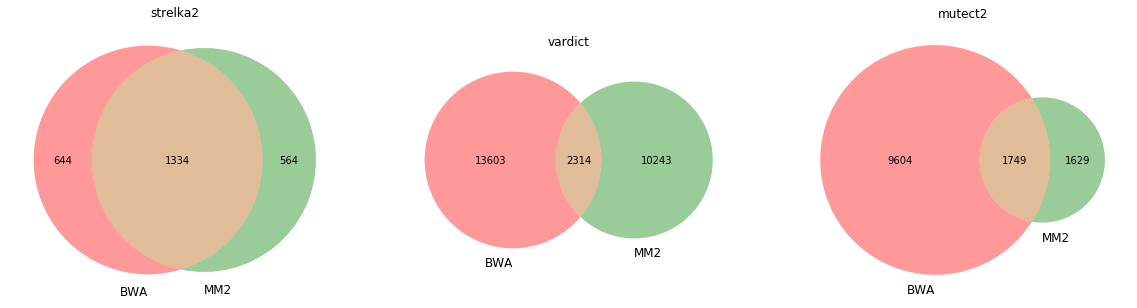

In [43]:
stats_by_chrom_by_caller = dict()

from matplotlib_venn import venn2, venn2_circles
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 10))
plt.title('BWA versus minimap2 calls for callers: ' + ', '.join(callers))
grid = gridspec.GridSpec(1, len(callers), width_ratios=[1] * len(callers))
for i, caller in enumerate(callers):
    # Printing FP/FN chromosome-wise stats
    print(caller)
    stats_by_chrom_by_caller[caller] = defaultdict(lambda: defaultdict(int))
    for category, g in df_by_c[caller].groupby(['bwa_validate', 'mm2_validate']):
        print(category, g.size)
        for _, r in g.iterrows():
            stats_by_chrom_by_caller[caller][r['chrom']][category] += 1
    
    # Plotting Venn
    ax = plt.subplot(grid[i])
    bwa_unique = sum(st[('tp', 'fn')] + st[('fp', 'tn')] for c, st in stats_by_chrom_by_caller[caller].items())
    mm2_unique = sum(st[('fn', 'tp')] + st[('tn', 'fp')] for c, st in stats_by_chrom_by_caller[caller].items())
    common     = sum(st[('tp', 'tp')] + st[('fp', 'fp')] for c, st in stats_by_chrom_by_caller[caller].items())
    subsets = {
        '10': bwa_unique,
        '01': mm2_unique,
        '11': common,
    }
    venn2(subsets, set_labels=('BWA', 'MM2'), ax=ax)
    ax.set_title(caller)
       
print(f'Done all')

[('1', 0), ('2', 249250621), ('3', 492449994), ('4', 690472424), ('5', 881626700), ('6', 1062541960), ('7', 1233657027), ('8', 1392795690), ('9', 1539159712), ('10', 1680373143), ('11', 1815907890), ('12', 1950914406), ('13', 2084766301), ('14', 2199936179), ('15', 2307285719), ('16', 2409817111), ('17', 2500171864), ('18', 2581367074), ('19', 2659444322), ('20', 2718573305), ('21', 2781598825), ('22', 2829728720), ('X', 2881033286), ('Y', 3036303846), ('MT', 3095677412), (None, 3095693981)]


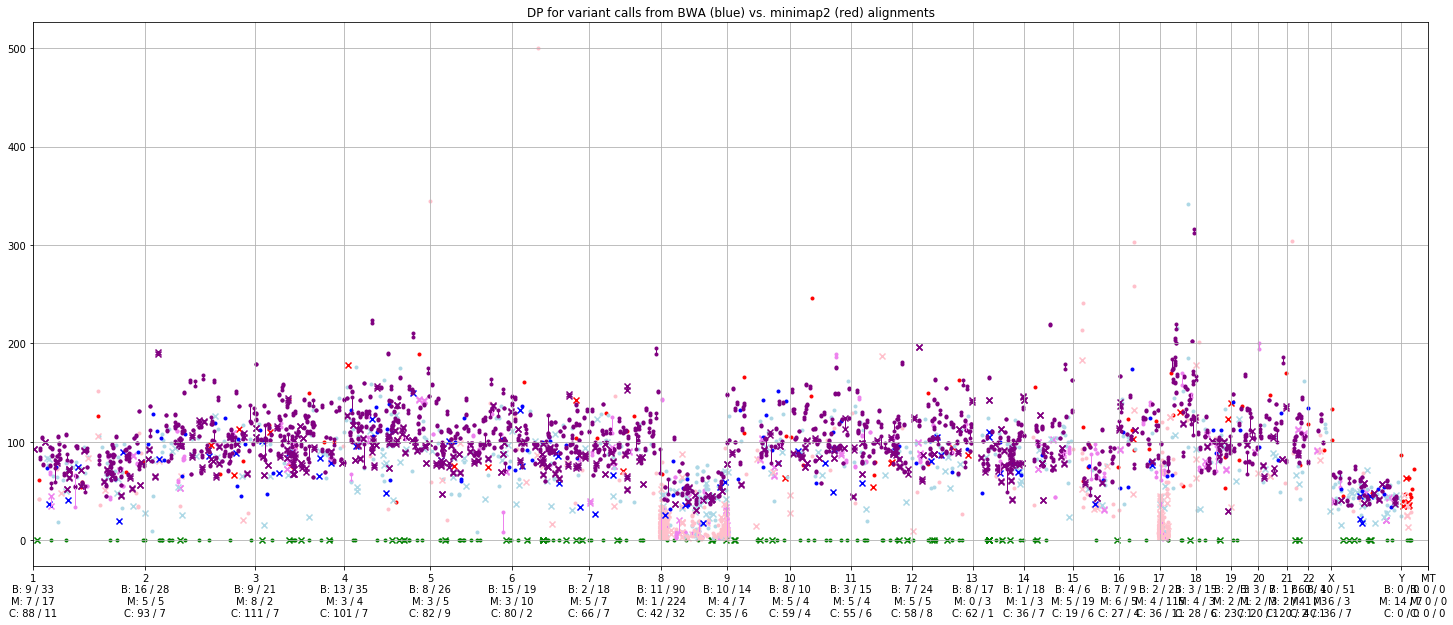

In [37]:
# Plotting functions

## Prepare colors for variant vs coordinate plots
from matplotlib.ticker import LinearLocator
#         mm2_tp                       mm2_fp                              mm2_fn              mm2_tn
# bwa_tp  purple conn red & blue dots  -                                   blue dot            -
# bwa_fp  -                            magenta conn pink & lightblue dots  -                   lightblue dot
# bwa_fn  red dot                      -                                   green dot at DP=-1  -
# bwa_tn  -                            pink dot                            -                   nothing
def set_color(d):
    if d['validate'] == 'fn':
        color = 'green'
        zorder = 2
    
    if not d['called_with_bwa']:
        assert d['called_with_mm2']
        color = 'lightblue'
        zorder = 0
        if d['validate'] == 'tp':
            color = 'blue'
            zorder = 1
            
    elif not d['called_with_mm2']:
        assert d['called_with_bwa']
        color = 'pink'
        zorder = 0
        if d['validate'] == 'tp':
            color = 'red'
            zorder = 1
            
    else:
        assert d['called_with_bwa']
        assert d['called_with_mm2']
        color = 'gray'
        zorder = 1
        if d['validate'] == 'tp':
            color = 'black'
            zorder = -1
    return color, zorder

def get_colors(category):
    """ Return color of BWA dot, color of minimap2 dot, and color of line connecting dots
    """
    
    if category == ('tp', 'tp'):
        return 'purple', 'purple', 'purple'

    elif category == ('tp', 'fn'):
        return 'blue', None, None
    
    elif category == ('fp', 'fp'):
        return 'violet', 'violet', 'violet'

    elif category == ('fp', 'tn'):
        return 'lightblue', None, None
        
    elif category == ('fn', 'tp'):
        return None, 'red', None
        
    elif category == ('fn', 'fn'):
        return 'green', None, None
        
    elif category == ('tn', 'fp'):
        return None, 'pink', None
    
    else:
        return None, None, None

# for caller in callers:
#     df_by_c[caller]['color']  = df_by_c[caller].apply(lambda row: set_color(row)[0], axis=1)
#     df_by_c[caller]['zorder'] = df_by_c[caller].apply(lambda row: set_color(row)[1], axis=1)
# print(f'Done colors')

## Plotting chromosome ticks
def draw_ticks(ax, chrom=None):
    chrom_poss = chrom_positions
    if chrom:
        print(chrom_positions)
        print(str(chrom))
        print(int_to_chrom(chrom_to_int(chrom) + 1))
        chrom_poss = [(c, p) for c, p in chrom_positions if c in [str(chrom), int_to_chrom(chrom_to_int(chrom) + 1)]]

    ax.set_xlim([chrom_poss[0][1], chrom_poss[-1][1]])
    
    return chrom_poss

## Plotting data
def plot(caller, field, field_name=None, chrom=None, diff=False, max_y=None):
    # Plotting MQ differrence by coordinate
    field_name = field_name or field.upper()

    fig = plt.figure(figsize=(25, 10))
    df = df_by_c[caller]
    ax = fig.add_subplot(111, label=f'{caller}_{field}', 
                         title=f'{field_name} for variant calls from BWA (blue) vs. minimap2 (red) alignments')

    chrom_poss = draw_ticks(ax, chrom)
    print(chrom_poss)
    
    modify = lambda v: v
    if max_y:
        modify = lambda v: v if v < 500 else 500
    
    # Plotting dots
    if diff:
        ax.scatter(df['x'], 
                   (df[f'bwa_{field}'] - df[f'mm2_{field}']).map(modify), 
                   marker='.', color=df['color'])
    else:
        for category, g in df.groupby(['bwa_validate', 'mm2_validate', 'tricky_anno']):
            (bwa_validate, mm2_validate, tricky_anno) = category
            bwa_color, mm2_color, line_color = get_colors((bwa_validate, mm2_validate))
            bys = g[f'bwa_{field}'].map(modify)
            mys = g[f'mm2_{field}'].map(modify)
            marker = '.' if not tricky_anno else 'x'
            if bwa_color:
                ax.scatter(g['x'], bys, marker=marker, color=bwa_color)
            if mm2_color:
                ax.scatter(g['x'], mys, marker=marker, color=mm2_color)
            if line_color:
                for index, row in g.iterrows():
                    by = modify(row[f'bwa_{field}'])
                    my = modify(row[f'mm2_{field}'])
                    ax.plot([row['x'], row['x']], [by, my], color=line_color, linewidth=1)
        
        s = stats_by_chrom_by_caller[caller]
        plt.xticks([pos for c, pos in chrom_poss],
                   ['\n'.join([f'{c}', 
#                               f'   {s[c][("tp", "tp")]} / {s[c][("tp", )]}', 
                               f'B: {s[c][("tp", "fn")]} / {s[c][("fp", "tn")]}', 
                               f'M: {s[c][("fn", "tp")]} / {s[c][("tn", "fp")]}', 
                               f'C: {s[c][("tp", "tp")]} / {s[c][("fp", "fp")]}']) if c else ''
                   for c, _ in chrom_poss])
            
#         grouped = df.groupby('zorder')
#         for zorder, g in grouped:
#             ax.scatter(g['x'], g[f'bwa_{field}'].map(modify), marker='.', color=g['color'], zorder=zorder)
#             ax.scatter(g['x'], g[f'mm2_{field}'].map(modify), marker='.', color=g['color'], zorder=zorder)

    ax.set_xlim([chrom_poss[0][1], chrom_poss[-1][1]])
    plt.grid()
    
    return df, ax

# df = df_by_c['strelka2']
# s1 = df['bwa_mq']
# s2 = df['mm2_mq']
# pd.concat([s1, s2], axis=0)

plot('strelka2', 'dp', max_y=500)
pass

Plotting variants with X axis as a genome position, and Y axis as a feature (MQ, DP, etc). 
- red dot represent a variant called with minimap2
- blue dot represent a variant called wit BWA
- variants called with both aligners are connected with vertical lines
- pale colors represent false positives, bright colors correspond to true positives
- green dots at the bottom represent shared false negatives (i.e. true variants not called with any aligner)
- those that overlap with low complexity or high/low tricky regions, scatterred with x; others scatterred with .

[('1', 0), ('2', 249250621), ('3', 492449994), ('4', 690472424), ('5', 881626700), ('6', 1062541960), ('7', 1233657027), ('8', 1392795690), ('9', 1539159712), ('10', 1680373143), ('11', 1815907890), ('12', 1950914406), ('13', 2084766301), ('14', 2199936179), ('15', 2307285719), ('16', 2409817111), ('17', 2500171864), ('18', 2581367074), ('19', 2659444322), ('20', 2718573305), ('21', 2781598825), ('22', 2829728720), ('X', 2881033286), ('Y', 3036303846), ('MT', 3095677412), (None, 3095693981)]
8
9
[('8', 1392795690), ('9', 1539159712)]


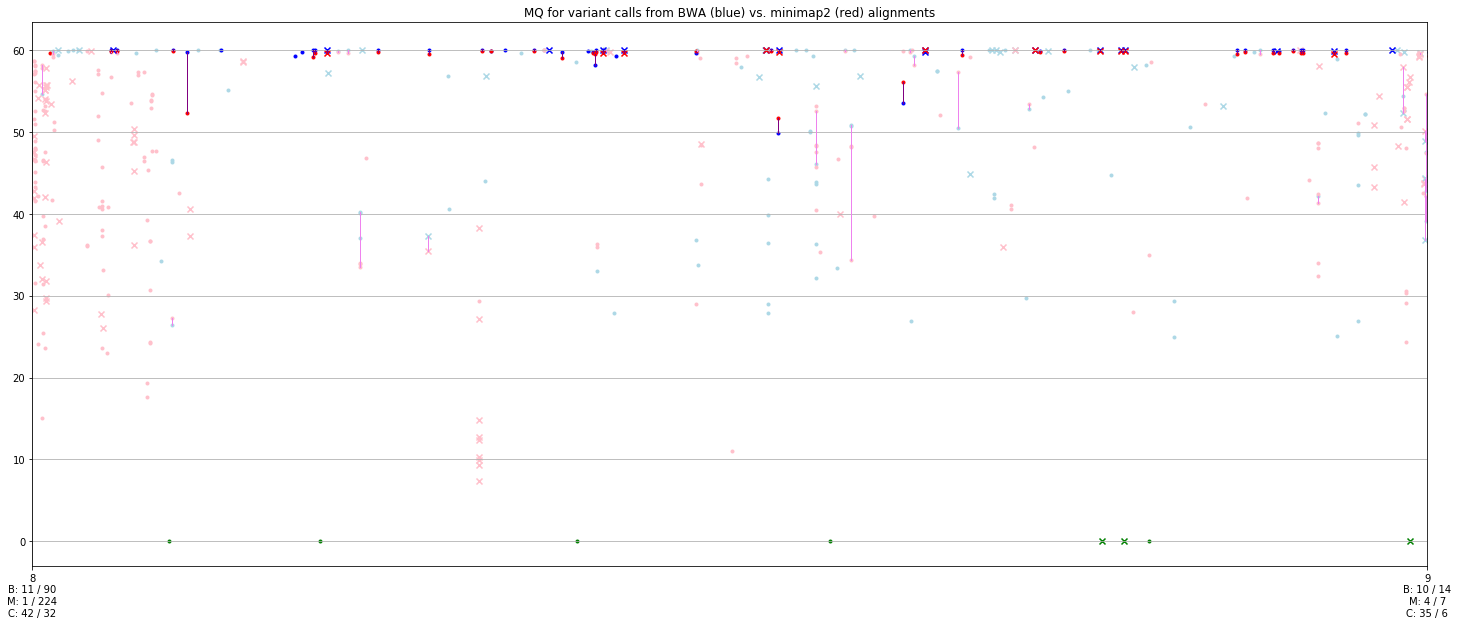

In [31]:
df, ax = plot('strelka2', 'mq', chrom=8)

# Annotate dots with gene names:
# for _, r in df[df[f'bwa_mq'] < 20][df[f'bwa_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'bwa_mq']))
# for _, r in df[df[f'mm2_mq'] < 20][df[f'mm2_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'mm2_mq']))

# Observations:
# - Chromosome 8: many bwa and minimap FP, but only few are shared.
# 
# TODO: 
# - ROC and other validatiopn stats based on MQ
# - Figure out high depth regions

[('1', 0), ('2', 249250621), ('3', 492449994), ('4', 690472424), ('5', 881626700), ('6', 1062541960), ('7', 1233657027), ('8', 1392795690), ('9', 1539159712), ('10', 1680373143), ('11', 1815907890), ('12', 1950914406), ('13', 2084766301), ('14', 2199936179), ('15', 2307285719), ('16', 2409817111), ('17', 2500171864), ('18', 2581367074), ('19', 2659444322), ('20', 2718573305), ('21', 2781598825), ('22', 2829728720), ('X', 2881033286), ('Y', 3036303846), ('MT', 3095677412), (None, 3095693981)]
8
9
[('8', 1392795690), ('9', 1539159712)]


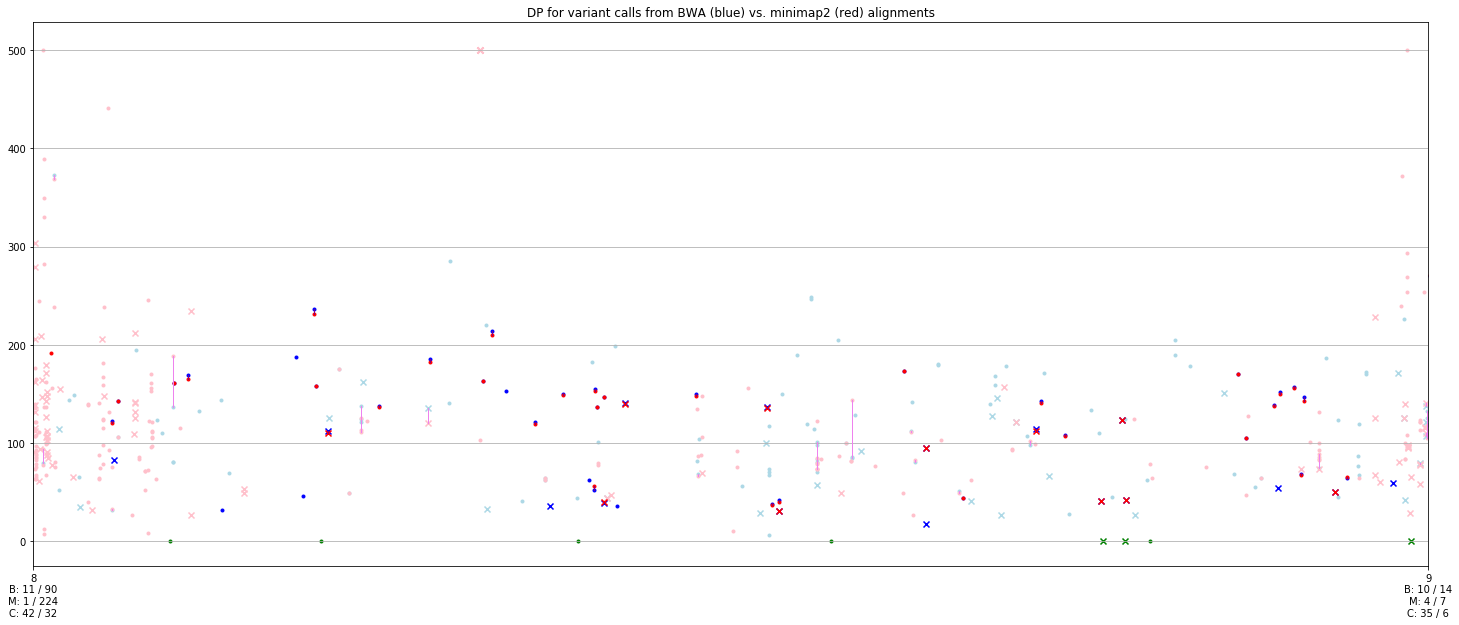

In [32]:
df, ax = plot('strelka2', 'dp', chrom=8, max_y=500)

KeyError: 'color'

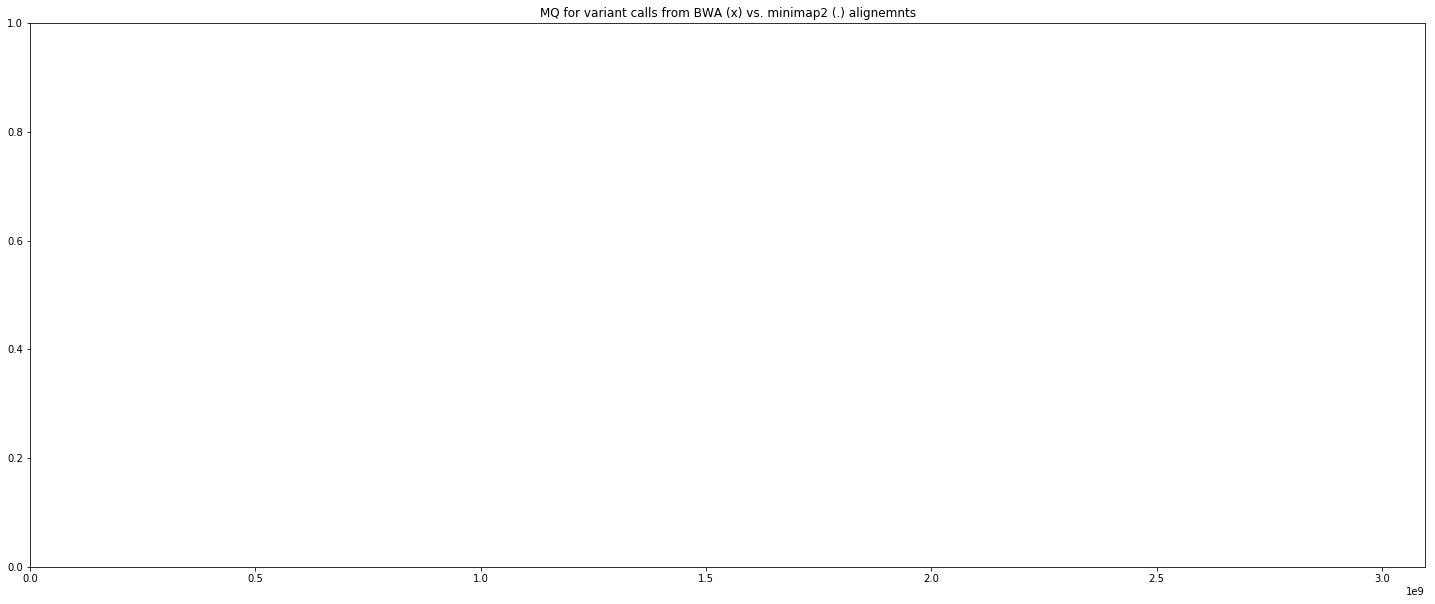

In [15]:
plot('strelka2', 'mq', diff=True)

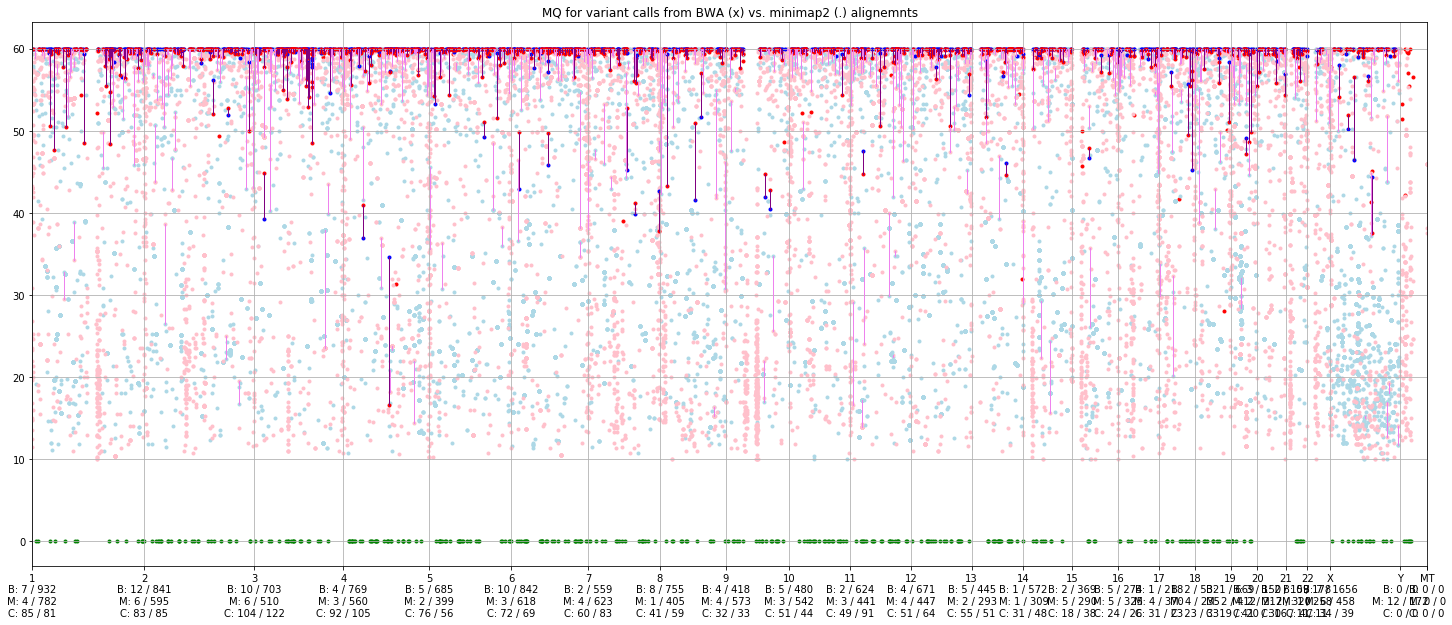

In [255]:
plot('vardict', 'mq')
pass

[('1', 0), ('2', 249250621), ('3', 492449994), ('4', 690472424), ('5', 881626700), ('6', 1062541960), ('7', 1233657027), ('8', 1392795690), ('9', 1539159712), ('10', 1680373143), ('11', 1815907890), ('12', 1950914406), ('13', 2084766301), ('14', 2199936179), ('15', 2307285719), ('16', 2409817111), ('17', 2500171864), ('18', 2581367074), ('19', 2659444322), ('20', 2718573305), ('21', 2781598825), ('22', 2829728720), ('X', 2881033286), ('Y', 3036303846), ('MT', 3095677412), (None, 3095693981)]


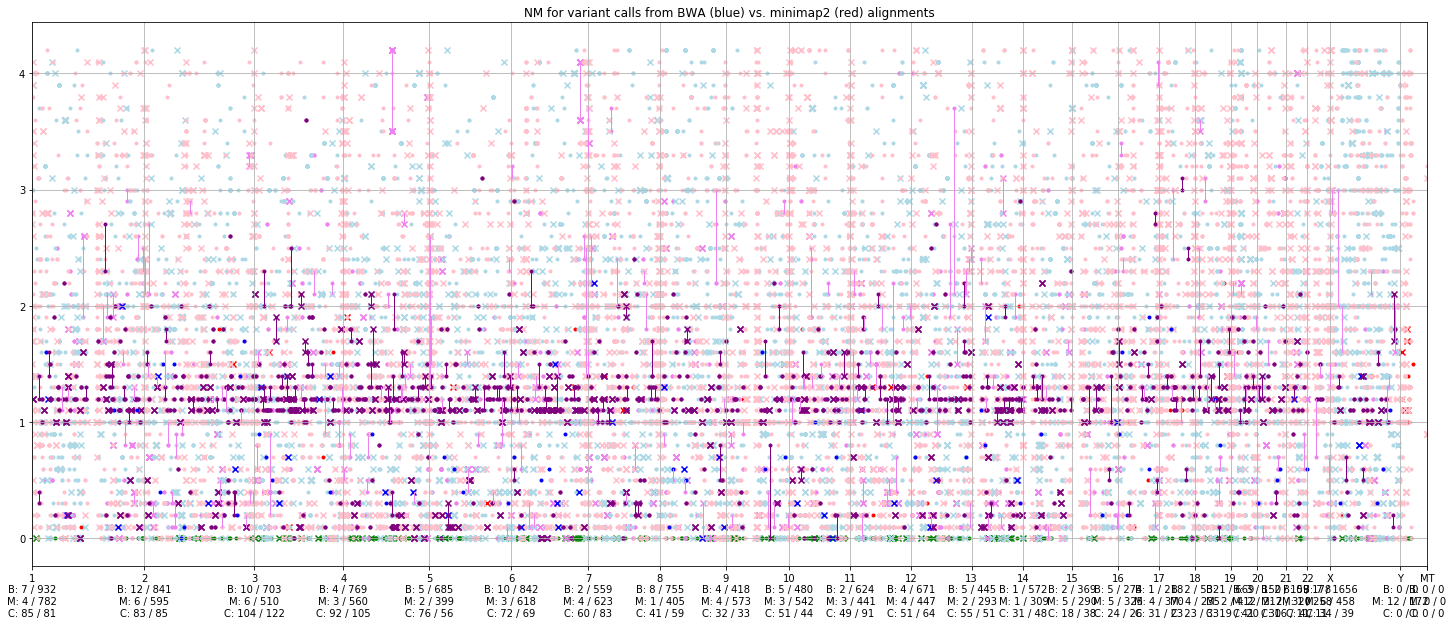

In [38]:
plot('vardict', 'nm')
pass

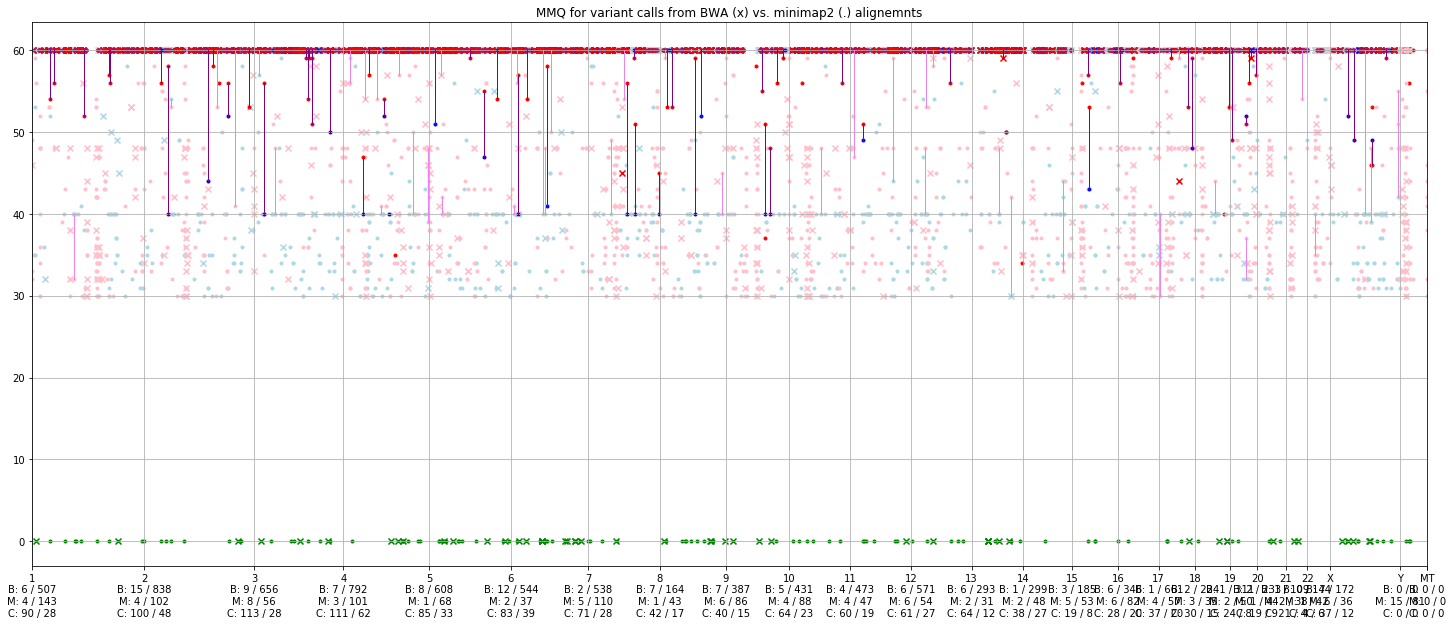

In [13]:
plot('mutect2', 'mq', 'MMQ')
pass

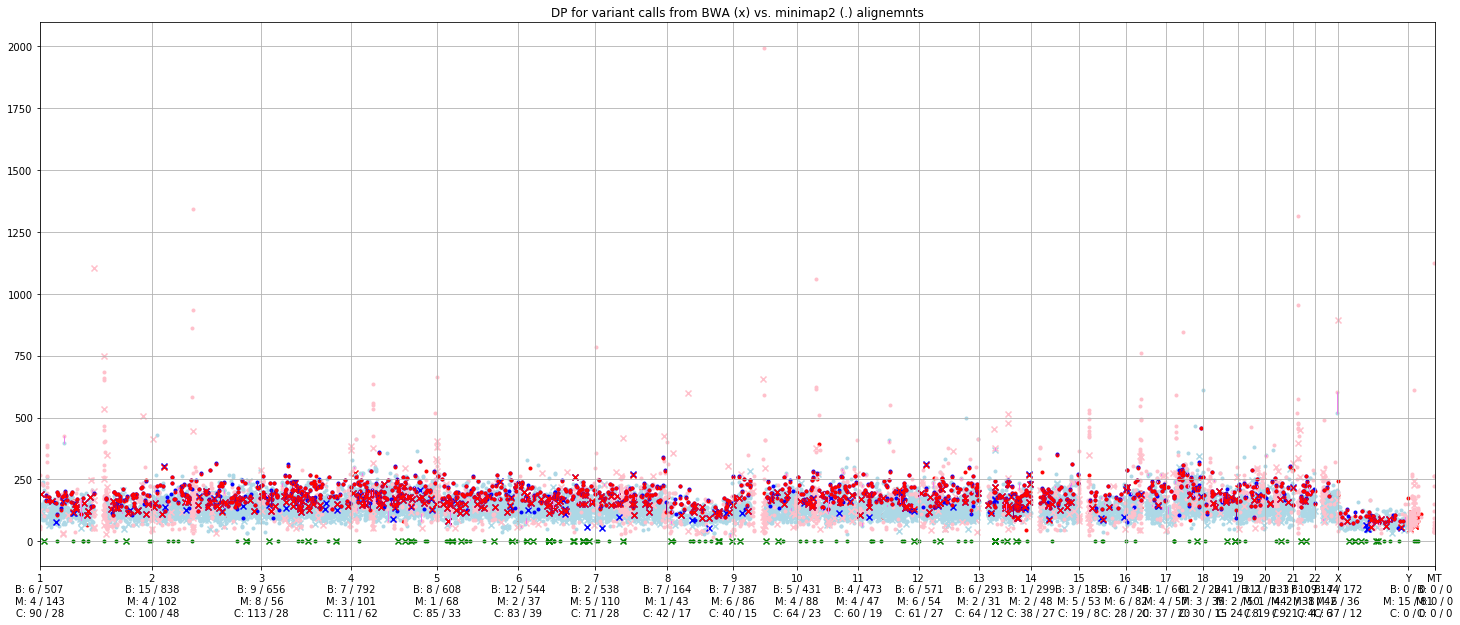

In [12]:
plot('mutect2', 'dp')
pass